# **Notebook for Text Alignment Using Fine-Tuned LaBSE Model**

Alignment is performed using the **[lingtrain aligner](https://github.com/averkij/lingtrain-aligner)** library

In [ ]:
!pip install seaborn more_itertools lingtrain-aligner==0.9.4 dateparser sentence_transformers sentencepiece transformers razdel datasets

In [ ]:
!mkdir ckt

In [ ]:
import seaborn as sns
import logging
from warnings import simplefilter
import sys
import os

from sentence_transformers import SentenceTransformer
from lingtrain_aligner import preprocessor, splitter, aligner, resolver, reader, helper, vis_helper, metrics

sns.set()

In [ ]:
# Configure logging
for handler in logging.root.handlers[:]:
    logging.root.removeHandler(handler)

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
simplefilter(action="ignore", category=FutureWarning)
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s [%(levelname)s] - %(process)d: %(message)s",
    datefmt="%d-%b-%y %H:%M:%S",
    handlers=[
        logging.StreamHandler(sys.stdout),
        logging.FileHandler("_aligner.log", mode="a"),
    ],
)
logging.getLogger("matplotlib.font_manager").disabled = True
logger = logging.getLogger(__name__)
logger.setLevel(logging.WARNING)  # Disabling INFO level logging

## **Loading Fine-Tuned Model from Hugging Face**

In [ ]:
model = SentenceTransformer("HSE-Chukchi-NLP/LaBSE-russian-chukchi")

### **Alternatively Load Fine-Tuned Model Locally**

In [ ]:
# !unzip ckt_labse_not_prepared_dataset.zip

Archive:  ckt_labse_not_prepared_dataset.zip
   creating: ckt_labse_not_prepared_dataset/
  inflating: ckt_labse_not_prepared_dataset/model.safetensors  
  inflating: ckt_labse_not_prepared_dataset/vocab.txt  
  inflating: ckt_labse_not_prepared_dataset/sentence_bert_config.json  
  inflating: ckt_labse_not_prepared_dataset/modules.json  
   creating: ckt_labse_not_prepared_dataset/3_Normalize/
   creating: ckt_labse_not_prepared_dataset/2_Dense/
  inflating: ckt_labse_not_prepared_dataset/2_Dense/model.safetensors  
  inflating: ckt_labse_not_prepared_dataset/2_Dense/config.json  
  inflating: ckt_labse_not_prepared_dataset/tokenizer_config.json  
  inflating: ckt_labse_not_prepared_dataset/config.json  
   creating: ckt_labse_not_prepared_dataset/1_Pooling/
  inflating: ckt_labse_not_prepared_dataset/1_Pooling/config.json  
  inflating: ckt_labse_not_prepared_dataset/config_sentence_transformers.json  
  inflating: ckt_labse_not_prepared_dataset/tokenizer.json  
  inflating: ckt_labs

In [ ]:
# model = SentenceTransformer("ckt_labse_final_dataset")

23-May-25 10:25:38 [INFO] - 220: Use pytorch device_name: cpu
23-May-25 10:25:38 [INFO] - 220: Load pretrained SentenceTransformer: ckt_labse_not_prepared_dataset


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


## **Preparing Texts**

Chukchi and Russian texts should be in a single file:
- Chukchi text first
- Followed by Russian text
- Separated by "ru:" marker

In [ ]:
input_file = "/content/chukot_article_7937.txt"

def read_combined_file(file_path, separator='ru:'):

    with open(file_path, "r", encoding="utf8") as f:
        lines = f.readlines()

    text1 = []
    text2 = []
    current_text = text1

    for line in lines:
        line = line.strip()
        if line == separator:
            current_text = text2
            continue
        if line:
            current_text.append(line)

    return text1, text2

text1, text2 = read_combined_file(input_file)

### **Marking Paragraphs**

In [ ]:
config_1 = {
    "type_1": preprocessor.PASS,
    "type_2": preprocessor.PASS,
    "roman": preprocessor.PASS,
    "arabic": preprocessor.PASS,
    "date": preprocessor.PASS,
    "misc": preprocessor.DIVIDER,
}
config_2 = {
    "type_1": preprocessor.PASS,
    "type_2": preprocessor.PASS,
    "roman": preprocessor.PASS,
    "arabic": preprocessor.PASS,
    "date": preprocessor.PASS,
    "misc": preprocessor.DIVIDER,
}

print("\n---------text1\n")
lines1_prepared = preprocessor.mark_headings(text1, config_1)
print("\n---------text2\n")
lines2_prepared = preprocessor.mark_headings(text2, config_2)

lines1_prepared = preprocessor.mark_paragraphs(lines1_prepared)
lines2_prepared = preprocessor.mark_paragraphs(lines2_prepared)


---------text1


---------text2



In [ ]:
lines1_prepared[:10]

['ТААРОҢГЫРГЫН, ЭЛЁЛЬЫЧЕТГЫРГЫН ЫНКЪАМ ҢЭЭ’ВИК%%%%%.',
 'Вера ТЭВЛЯНТО, урэмигчирэтыльын қорагынрэтгыргык, Эквыыннот%%%%%.',
 'Талпыӈӈок февральининик март эмнуӈыльыт нытэнмавӄэнат Тэркыӄаматынвэты, ыьтри ныялгытӄэнат торавээнвэты, торралӄаӈынвык нытаароӈӄэнат, ялгытыркыт торавээнвэты, торралӄаӈынвык таароӈыркыт, рагролмын гытамо нэлгыркын миӈкриым эргатык рэмкын льаляӈэтынвэты ратэнмавӈыт%%%%%.',
 'Еп рэювкы вулӄытвик ӈавэтынва етьа рытчыркынин рэнтыткоолӄылтэ нотатаароӈкэн льаляӈэтынвэты. Ройыръэн эвиръыт рытэнмавыркынэнат, инъэ таӈгаглыйпы. Етьа рытчыркынинэт уттыт увинтэткин ынкъам гытамэты рытрилыркынинэт этролклыӄылтэ. Ы’ттьыт омрыквотыркынэнат аръасэнтыкэгты. Ӄэлёӄ-ым гытамо нылгыӄинэт, нэкэм таароӈыӈӈок. гыгэру ныльгыӄинэт ымы мэйӈыӄулильэтык. Ынкъам нывириӈкинэт майӈывэтгавыльыт. Кимылтэтыльыт экэвку нылгыӄинэт, нэкэм ӈэвъэнйыръыт. Инъэ ривыльэ рыпкирэтыркынин ӈэлвыл, лыгэнэвыт ӄутти ӄлявылтэ гырыткугилиркыт%%%%%.',
 'Эвыт тангиянъё кынъоёлӄыл ӄораӈы эвытрыкэ вак, э’ми ӄаачыко

### **Creating Aligned Database**

In [ ]:
lang_from = "ckt"
lang_to = "ru"

db_path = "3_extract_pairs.db"

In [ ]:
splitted_from = splitter.split_by_sentences_wrapper(lines1_prepared, lang_from)
splitted_to = splitter.split_by_sentences_wrapper(lines2_prepared, lang_to)

for i, s in enumerate(splitted_from[0:10]):
    print(i, "-", s)
print("\n")
for i, s in enumerate(splitted_to[0:10]):
    print(i, "-", s)

print("\n---------------------------------\n\n")
print("len from:", len(splitted_from))
print("len to:", len(splitted_to))

0 - ТААРОҢГЫРГЫН, ЭЛЁЛЬЫЧЕТГЫРГЫН ЫНКЪАМ ҢЭЭ’ВИК%%%%%.
1 - Вера ТЭВЛЯНТО, урэмигчирэтыльын қорагынрэтгыргык, Эквыыннот%%%%%.
2 - Талпыӈӈок февральининик март эмнуӈыльыт нытэнмавӄэнат Тэркыӄаматынвэты, ыьтри ныялгытӄэнат торавээнвэты, торралӄаӈынвык нытаароӈӄэнат, ялгытыркыт торавээнвэты, торралӄаӈынвык таароӈыркыт, рагролмын гытамо нэлгыркын миӈкриым эргатык рэмкын льаляӈэтынвэты ратэнмавӈыт%%%%%.
3 - Еп рэювкы вулӄытвик ӈавэтынва етьа рытчыркынин рэнтыткоолӄылтэ нотатаароӈкэн льаляӈэтынвэты.
4 - Ройыръэн эвиръыт рытэнмавыркынэнат, инъэ таӈгаглыйпы.
5 - Етьа рытчыркынинэт уттыт увинтэткин ынкъам гытамэты рытрилыркынинэт этролклыӄылтэ.
6 - Ы’ттьыт омрыквотыркынэнат аръасэнтыкэгты.
7 - Ӄэлёӄ-ым гытамо нылгыӄинэт, нэкэм таароӈыӈӈок. гыгэру ныльгыӄинэт ымы мэйӈыӄулильэтык.
8 - Ынкъам нывириӈкинэт майӈывэтгавыльыт.
9 - Кимылтэтыльыт экэвку нылгыӄинэт, нэкэм ӈэвъэнйыръыт.


0 - ОБРЯД, СОСТЯЗАНИЯ И СВАТОВСТВО%%%%%.
1 - Вера ТЕВЛЯНТО, ветеран оленеводства, городской округ Эгвекинот%%%%%.
2 - В

In [ ]:
import os
if os.path.isfile(db_path):
    os.remove(db_path)

In [ ]:
if os.path.isfile(db_path):
    os.unlink(db_path)

aligner.fill_db(db_path, lang_from, lang_to, splitted_from, splitted_to)

23-May-25 12:35:43 [INFO] - 220: Initializing database 3_extract_pairs.db


### **Segmentation**

In [ ]:
left_segments, right_segments = aligner.calculate_segments(
    db_path, segmentation_marks=[preprocessor.H2]
)

segments_structure = aligner.get_batch_intersected_for_segments_list(
    db_path, left_segments=left_segments, right_segments=right_segments, batch_size=200
)

segments_structure

[[0]]

In [ ]:
# use_segments = True
use_segments = False

batch_ids = range(0, 20)

aligner.align_db(
    db_path,
    model_name="_",
    batch_size=200,
    window=40,
    batch_ids=batch_ids,
    save_pic=False,
    embed_batch_size=100,
    normalize_embeddings=True,
    show_progress_bar=False,
    shift=0,
    model=model,
    use_segments=use_segments,
    segmentation_marks=[preprocessor.H2],
)

Aligning without segments.
tasks amount: 1
batch: 0 (0)
23-May-25 12:35:44 [INFO] - 220: Batch 0. Calculating vectors.
23-May-25 12:35:55 [WARNING] - 220: can not fetch index db


In [ ]:
print("score 1:", metrics.chain_score(db_path))

score 1: 0.1333333333333333


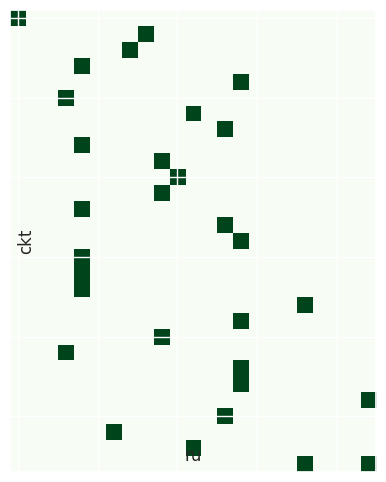

In [ ]:
vis_helper.visualize_alignment_by_db(
    db_path,
    output_path="alignment_vis.png",
    # batch_size=0 if use_segments else 1000,
    batch_size=400,
    size=(600, 600),
    lang_name_from=lang_from,
    lang_name_to=lang_to,
    batch_ids=batch_ids,
    plt_show=True,
)

## **Resolving Conflicts**

In [ ]:
import time
start_time = time.time()

steps = 3
batch_id = -1
for i in range(steps):
    conflicts, rest = resolver.get_all_conflicts(db_path, min_chain_length=2+i, max_conflicts_len=6*(i+1), batch_id=batch_id)
    resolver.get_statistics(conflicts)
    resolver.get_statistics(rest)

    resolver.resolve_all_conflicts(db_path, conflicts, model_name="_", show_logs=False, model=model)

    print("--------------------------------\nresolved. step", i+1)
    print("score 1:", metrics.chain_score(db_path))
    print("score 2:", metrics.chain_score(db_path, mode="both"),"\n------------------------------")

    if len(rest) == 0:
        break

conflicts, rest = resolver.get_all_conflicts(db_path, min_chain_length=2, max_conflicts_len=26, batch_id=batch_id)
resolver.get_statistics(conflicts)
resolver.get_statistics(rest)

resolver.resolve_all_conflicts(db_path, conflicts, model_name="_", show_logs=False, model=model)

print("calculated --- %s seconds ---" % (time.time() - start_time))

conflicts to solve: 1
total conflicts: 2
('4:4', 1)
('10:10', 1)


100%|██████████| 1/1 [00:01<00:00,  1.16s/it]


--------------------------------
resolved. step 1
score 1: 0.23333333333333328
score 2: 0.6166666666666667 
------------------------------
conflicts to solve: 0
total conflicts: 0


0it [00:00, ?it/s]


--------------------------------
resolved. step 2
score 1: 0.23333333333333328
score 2: 0.6166666666666667 
------------------------------
conflicts to solve: 1
total conflicts: 1
('10:10', 1)


100%|██████████| 1/1 [00:04<00:00,  4.30s/it]

calculated --- 5.477943420410156 seconds ---


## **Resolving Conflicts (Strategy 2)**

In [ ]:
min_chain_length = 2
max_conflicts_len = 26

while True:
    conflicts, rest_conflicts = resolver.get_all_conflicts(
                    db_path,
                    min_chain_length=min_chain_length,
                    max_conflicts_len=max_conflicts_len,
                    batch_id=batch_id,
                    handle_start=True,
                    handle_finish=True,
                )
    fixed_conflicts = resolver.correct_conflicts(
                    db_path,
                    rest_conflicts,
                    batch_id=batch_id,
                    min_chain_length=min_chain_length,
                    max_conflicts_len=max_conflicts_len,
                    handle_start=True,
                    handle_finish=True,
                )
    if not fixed_conflicts:
        break

    resolver.resolve_all_conflicts(
                    db_path,
                    conflicts,
                    model_name="_",
                    show_logs=False,
                    model=model
                )


conflicts to solve: 1
total conflicts: 1
23-May-25 12:36:01 [INFO] - 220: Trying to decrease a number of unused conflicts. Fixing negative lenghts.
23-May-25 12:36:01 [INFO] - 220: Found 0 conflicts with negative length.
conflicts to solve: 1
total conflicts: 1
23-May-25 12:36:01 [INFO] - 220: 0 was fixed.


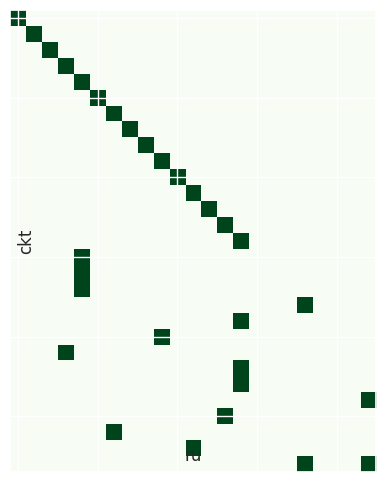

In [ ]:
vis_helper.visualize_alignment_by_db(db_path,
            output_path="alignment_vis.png",
            batch_size=600,
            size=(600,600),
            lang_name_from=lang_from,
            lang_name_to=lang_to,
            # batch_ids=batch_ids,
            plt_show=True)

In [ ]:
print("score 1:", metrics.chain_score(db_path))

score 1: 0.5333333333333333


## **Extracting Pairs**

In [ ]:
pairs = reader.get_aligned_pair_chains(db_path, min_len=3)

In [ ]:
len(pairs)

16

Skipping pairs with significant length differences

In [ ]:
res = []

for p in pairs:
    if len(p[0])/len(p[1]) > 1.8 or len(p[0])/len(p[1]) < 0.6:
        continue
    res.append(p)

len(res), res

(10,
 [['ТААРОҢГЫРГЫН, ЭЛЁЛЬЫЧЕТГЫРГЫН ЫНКЪАМ ҢЭЭ’ВИК.',
   'ОБРЯД, СОСТЯЗАНИЯ И СВАТОВСТВО.'],
  ['Вера ТЭВЛЯНТО, урэмигчирэтыльын қорагынрэтгыргык, Эквыыннот.',
   'Вера ТЕВЛЯНТО, ветеран оленеводства, городской округ Эгвекинот.'],
  ['Еп рэювкы вулӄытвик ӈавэтынва етьа рытчыркынин рэнтыткоолӄылтэ нотатаароӈкэн льаляӈэтынвэты.',
   'Кочуют на новые, непротоптанные пастбища, где олени смогут спокойно пастись.'],
  ['Ройыръэн эвиръыт рытэнмавыркынэнат, инъэ таӈгаглыйпы.',
   'В дни проведения обряда оленеводы по-особенному относятся к стаду.'],
  ['Етьа рытчыркынинэт уттыт увинтэткин ынкъам гытамэты рытрилыркынинэт этролклыӄылтэ.',
   'Они стараются лишний раз не тревожить отдыхающих оленей, громко не разговаривают.'],
  ['Инъэ ривыльэ рыпкирэтыркынин ӈэлвыл, лыгэнэвыт ӄутти ӄлявылтэ гырыткугилиркыт.',
   'Утром ночной дежурный пригоняет стадо, другие мужчины принимают его и выбирают жертвенного оленя, намеченного заранее.'],
  ['Эвыт тангиянъё кынъоёлӄыл ӄораӈы эвытрыкэ вак, э’ми ӄаач

## **Saving Results**

In [ ]:
import pandas as pd

# Saving to CSV
df = pd.DataFrame(res, columns=["ckt", "ru"])

In [ ]:
df

,ckt,ru
0,"ТААРОҢГЫРГЫН, ЭЛЁЛЬЫЧЕТГЫРГЫН ЫНКЪАМ ҢЭЭ’ВИК.","ОБРЯД, СОСТЯЗАНИЯ И СВАТОВСТВО."
1,"Вера ТЭВЛЯНТО, урэмигчирэтыльын қорагынрэтгырг...","Вера ТЕВЛЯНТО, ветеран оленеводства, городской..."
2,Еп рэювкы вулӄытвик ӈавэтынва етьа рытчыркынин...,"Кочуют на новые, непротоптанные пастбища, где ..."
3,"Ройыръэн эвиръыт рытэнмавыркынэнат, инъэ таӈга...",В дни проведения обряда оленеводы по-особенном...
4,Етьа рытчыркынинэт уттыт увинтэткин ынкъам гыт...,Они стараются лишний раз не тревожить отдыхающ...
5,"Инъэ ривыльэ рыпкирэтыркынин ӈэлвыл, лыгэнэвыт...","Утром ночной дежурный пригоняет стадо, другие ..."
6,"Эвыт тангиянъё кынъоёлӄыл ӄораӈы эвытрыкэ вак,...",Если этот олень не попадает в поле зрения – пр...
7,"Ръэнут винвынъэӄэрэвын, иа’м тыӈэво лыӈыркын, ...",Если же жертвенное животное без помех поймали ...
8,Ымылыгэн аманъята нытчыӄин.,Тут начинается самое интересное.
9,Тиркыӄэмэтык ачгыта чама тымӈалголяӄ ныръилеӄи...,В состязании охотно принимают участие и стар и...


In [ ]:
df.to_csv("extra_chukot_article_7937.csv", index=False, encoding="utf-8-sig")